In [1]:
import os
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PowerTransformer, StandardScaler
from scipy.stats import skew
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D

file_path = os.path.join(os.getcwd(), "datasets", "London.csv")
housing = pd.read_csv(file_path)
housing.head()

,Unnamed: 0,Property Name,Price,House Type,Area in sq ft,No. of Bedrooms,No. of Bathrooms,No. of Receptions,Location,City/County,Postal Code
0,0,Queens Road,1675000,House,2716,5,5,5,Wimbledon,London,SW19 8NY
1,1,Seward Street,650000,Flat / Apartment,814,2,2,2,Clerkenwell,London,EC1V 3PA
2,2,Hotham Road,735000,Flat / Apartment,761,2,2,2,Putney,London,SW15 1QL
3,3,Festing Road,1765000,House,1986,4,4,4,Putney,London,SW15 1LP
4,4,Spencer Walk,675000,Flat / Apartment,700,2,2,2,Putney,London,SW15 1PL


In [2]:
housing.drop("Unnamed: 0", axis=1, inplace=True)
housing.head()
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3480 entries, 0 to 3479
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Property Name      3480 non-null   object
 1   Price              3480 non-null   int64 
 2   House Type         3480 non-null   object
 3   Area in sq ft      3480 non-null   int64 
 4   No. of Bedrooms    3480 non-null   int64 
 5   No. of Bathrooms   3480 non-null   int64 
 6   No. of Receptions  3480 non-null   int64 
 7   Location           2518 non-null   object
 8   City/County        3480 non-null   object
 9   Postal Code        3480 non-null   object
dtypes: int64(5), object(5)
memory usage: 272.0+ KB


In [3]:
# rename columns
housing = housing.rename(columns={
    "Property Name": "property_name",
    "Price": "price", 
    "House Type": "house_type", 
    "Area in sq ft": "area_in_sqft", 
    "No. of Bedrooms": "no_bedrooms", 
    "Location": "location", 
    "City/County": "county", 
    "Postal Code": "postal_code"
})

`Location` column is missing 962 records - need to fill that in later.

In [4]:
# this may not useful column? unsure
non_numericals = ['property_name', 'house_type', 'location', 'county', 'postal_code']
for obj_col in non_numericals:
    print(housing[obj_col].value_counts())
    print("", end='\n\n')

property_name
Television Centre    17
City Road            14
Bishops Gate         14
Eaton Square         11
Junction House        8
                     ..
Norfolk Mansions      1
Springfield Road      1
Liberty House         1
Ravens Close          1
One Lillie Square     1
Name: count, Length: 2380, dtype: int64


house_type
Flat / Apartment    1565
House               1430
New development      357
Penthouse            100
Studio                10
Bungalow               9
Duplex                 7
Mews                   2
Name: count, dtype: int64


location
Putney               96
Barnes               71
Wandsworth           70
Wimbledon            68
Esher                64
                     ..
Aberdeen Park         1
Southgate Road        1
 Dalston              1
162 Gideon Road       1
 Waterfront Drive     1
Name: count, Length: 656, dtype: int64


county
London                      2972
Surrey                       262
Middlesex                     78
Essex                

## Non-Numerical Data
there are 2380 `Property Names`, not sure if they are necessary since there are `Location` column
`House Type` can be used as categorical properties converted to a integer.
`City/County` column seems to be very messy, unorganised and kinda duplicate with location, so might be dropping it.
`Postal Code` will be meaningful as an indicator to more specific location, but need to keep the first bit. 

In [5]:
housing.describe()

,price,area_in_sqft,no_bedrooms,No. of Bathrooms,No. of Receptions
count,3.480000e+03,3480.000000,3480.000000,3480.000000,3480.000000
mean,1.864173e+06,1712.973563,3.103736,3.103736,3.103736
std,2.267283e+06,1364.259351,1.517698,1.517698,1.517698
min,1.800000e+05,274.000000,0.000000,0.000000,0.000000
25%,7.500000e+05,834.000000,2.000000,2.000000,2.000000
50%,1.220000e+06,1310.000000,3.000000,3.000000,3.000000
75%,2.150000e+06,2157.250000,4.000000,4.000000,4.000000
max,3.975000e+07,15405.000000,10.000000,10.000000,10.000000


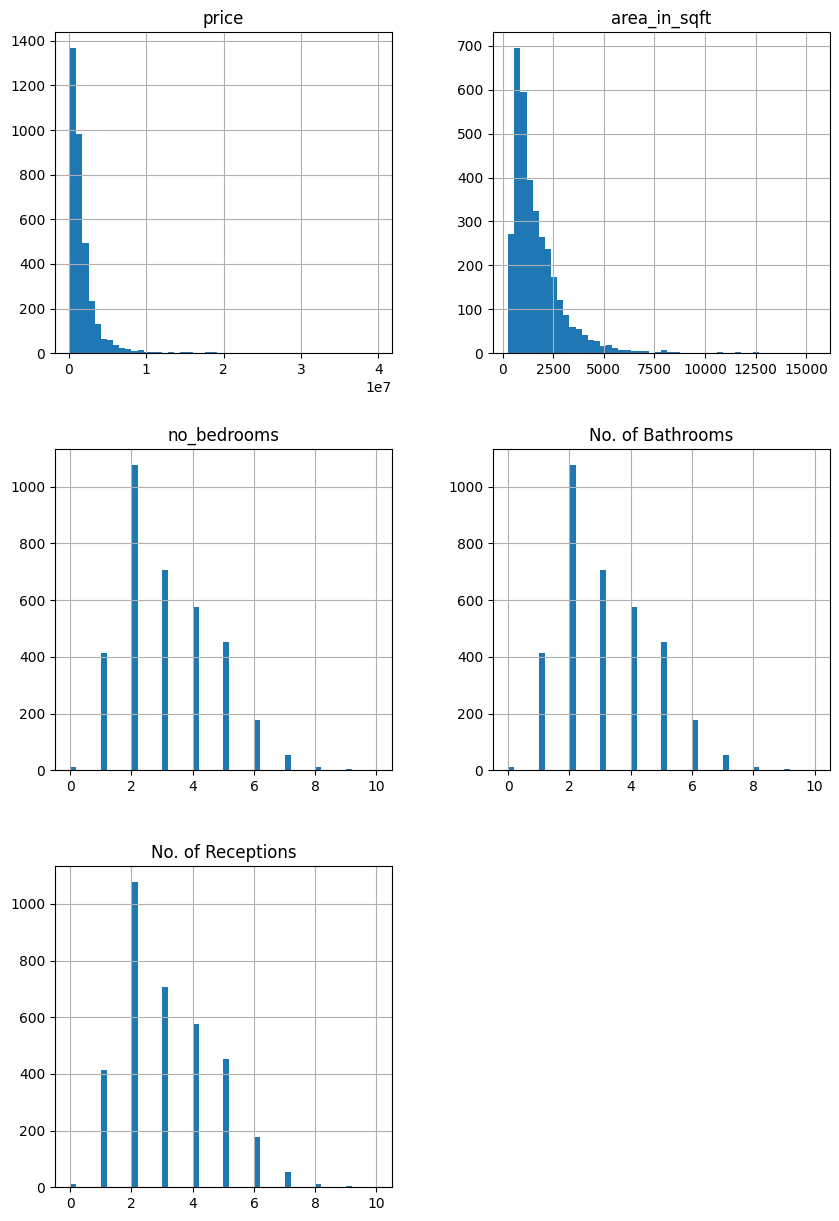

In [6]:
housing.hist(bins=50, figsize=(10,15))
plt.show()

The target value `Prices` over 3000 houses in london are ranging from 0 - 10 million, we may want to keep this ratio of population to avoid bias in sampling. It's tail-heavy distributions, standardization or normalization is required.

Stratified split requires categorizing of the dataset, to split the ranges of prices, so that the StratifiedShuffleSplit can see the ratio of population of dataset depending on it.

<Axes: >

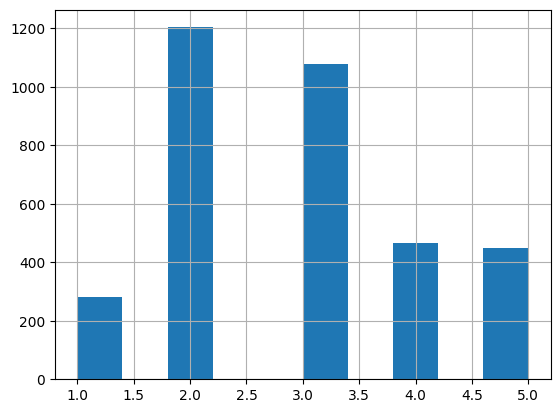

In [7]:
# categorise price
housing["price_cat"] = pd.cut(
    housing["price"],
    bins=[0, 500000, 1000000, 2000000, 3000000, np.inf],
    labels=[1,2,3,4,5])
housing["price_cat"].hist()

In [8]:
# slpit stratified test and train set based on price bound categories
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["price_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [9]:
# price_cat is now part of strat data set, we don't need this anymore so need to drop
strat_train_set.head()
for set_ in (strat_train_set, strat_test_set):
    set_.drop("price_cat", axis=1, inplace=True)

In [10]:
# take train set
housing = strat_train_set.copy()

In [11]:
# drop non numerical columns to correlation calculation
property_name = housing['property_name'].copy()
house_type = housing['house_type'].copy()
location = housing['location'].copy()
city_county = housing['county'].copy()
postal_code = housing['postal_code'].copy()
for col_name in non_numericals:
    housing.drop(col_name, axis=1, inplace=True)

In [12]:
# correlation with Price matrix
corr_matrix = housing.corr()
print(corr_matrix["price"])

price                1.000000
area_in_sqft         0.643649
no_bedrooms          0.432813
No. of Bathrooms     0.432813
No. of Receptions    0.432813
Name: price, dtype: float64


Area seems to be the strongly correlated

<Axes: >

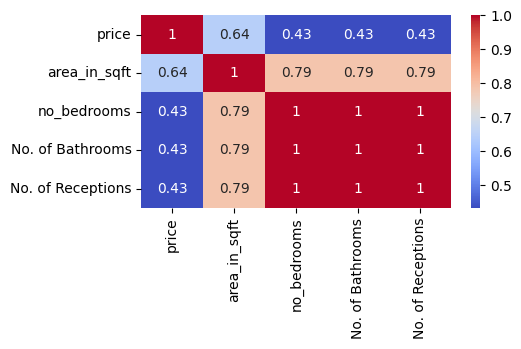

In [13]:
plt.figure(figsize=(5,2.5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

### multicollinearity - address features that are highly correlated with each other
No bedrooms and no. of Bathrooms and No.receptions seems to be highly related each other. Those features provide similar information. Including all of them might not improve the model's predictive performance but could increase its complexity unnecessarily.

High multicollinearity makes it harder to interpret the importance of individual features because their effects on the target variable can overlap.

Dropping one or more highly correlated features simplifies the model, reduces overfitting, and makes training faster.

In this case, `No. of bedrooms`, `No.of Bathrooms`, and `No.of Receptions` have lower correlations with price(0.44). If features contribute little to predicting `Price` but are highly correlated with other features, they are candidates for removal.

Having said that, these feature could add some value when combined with other features. so keep only one, `No. of bedrooms`

In [14]:
housing.drop("No. of Bathrooms", axis=1, inplace=True)
housing.drop("No. of Receptions", axis=1, inplace=True)

<Axes: xlabel='area_in_sqft', ylabel='price'>

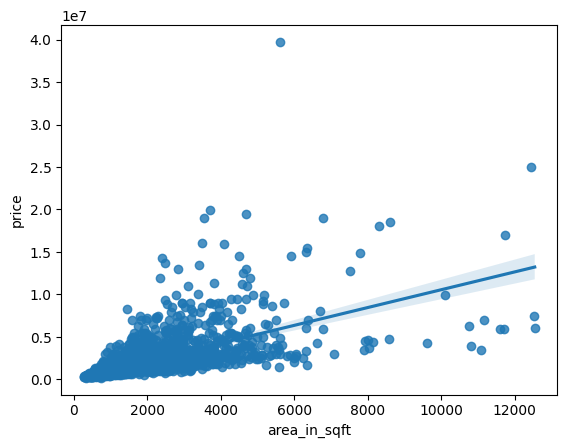

In [15]:
sns.regplot(y=housing['price'], x=housing['area_in_sqft'])

This chart shows that there is dense points at the beginning and wide scatter as grows indicates that the relationship might not be purely linear. Meaning, I should explore non-numerical features, by encoding them.

`property_name` is highly granular feature, with most values being unique. It doesn't generalize well for predictive purposes. so drop this column

`house_type` has a manageable number of categories. It can be very predictive because property type often affects price.

`location` has many unique values (656 total) but fewer than postal code.

`county` has some entries that are inconsistent. 

`postal_code` has the highest unique features, but it comes across categorizable by the first post code. Truncate postal codes might do it.

<Axes: xlabel='no_bedrooms', ylabel='price'>

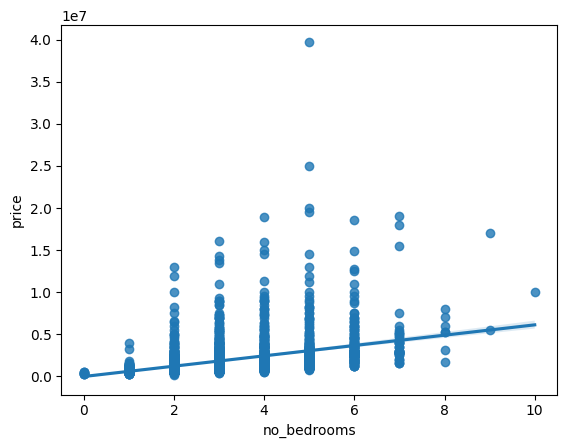

In [16]:
sns.regplot(y=housing['price'], x=housing['no_bedrooms'])

### Explore House Type

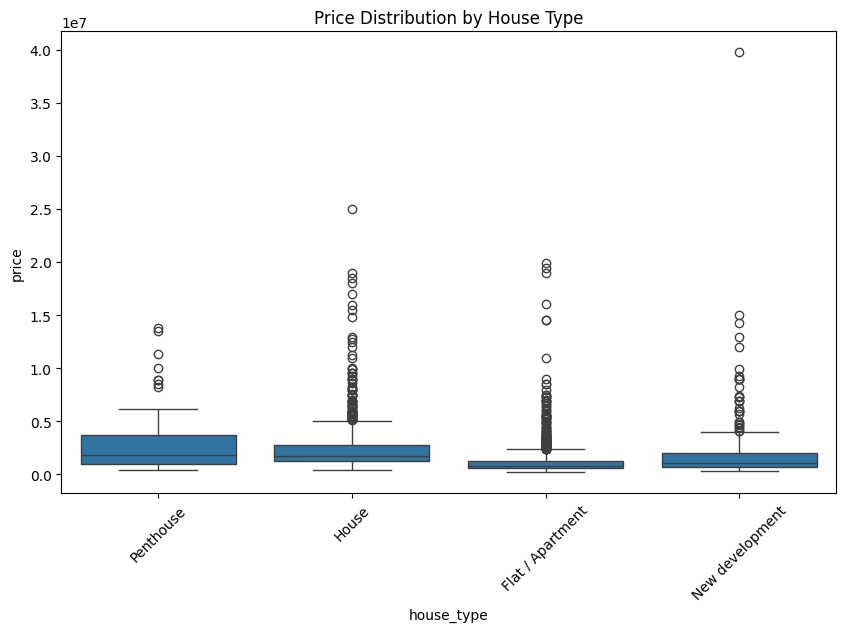

In [17]:
# box plot for homogeneity of Variance

# merging categories
house_type = house_type.replace(["Bungalow", "Duplex", "Mews"], "House")
house_type = house_type.replace("Studio", "Flat / Apartment")

temp_df = housing.copy()
house_type = house_type.reset_index(drop=True)
temp_df = temp_df.reset_index(drop=True)
temp_df['house_type'] = house_type

plt.figure(figsize=(10,6))
sns.boxplot(data=temp_df, x="house_type", y="price")
plt.xticks(rotation=45)
plt.title("Price Distribution by House Type")
plt.show()

### Check Homogeneity of Variance
Compare the spread of prices across house types, For ANOVA, we expect that the spread (variance) of prices across house types is relatively similar.

### Reading box plot
1. Median of the penthouse is much higher than other types like flat or studio. (line in the box)
2. 25th percentile and 75th percentile (start and end of box) of duplex and mews indicate a smaller price variation, wherease penthouse has a wider price variation
3. New development and house have relatively large whiskers, indicating a wider spread of prices compared to Studio. Whiskers(Line above/below the box showing the range of most data points)
4. Penthouse, flat, house have several outliers, suggesting there are very expensive properties in these categories

**Price Drivers**
The wide price range for penthouse indicates it might be a significant predictor of high prices.  

Studio has minimal price variability, suggesting its prices are more predictable and lower.

**Data Preprocessing**
Since some house types like mews, bungalow and duplex have very few data points, consider grouping them to house, and studio to flat.


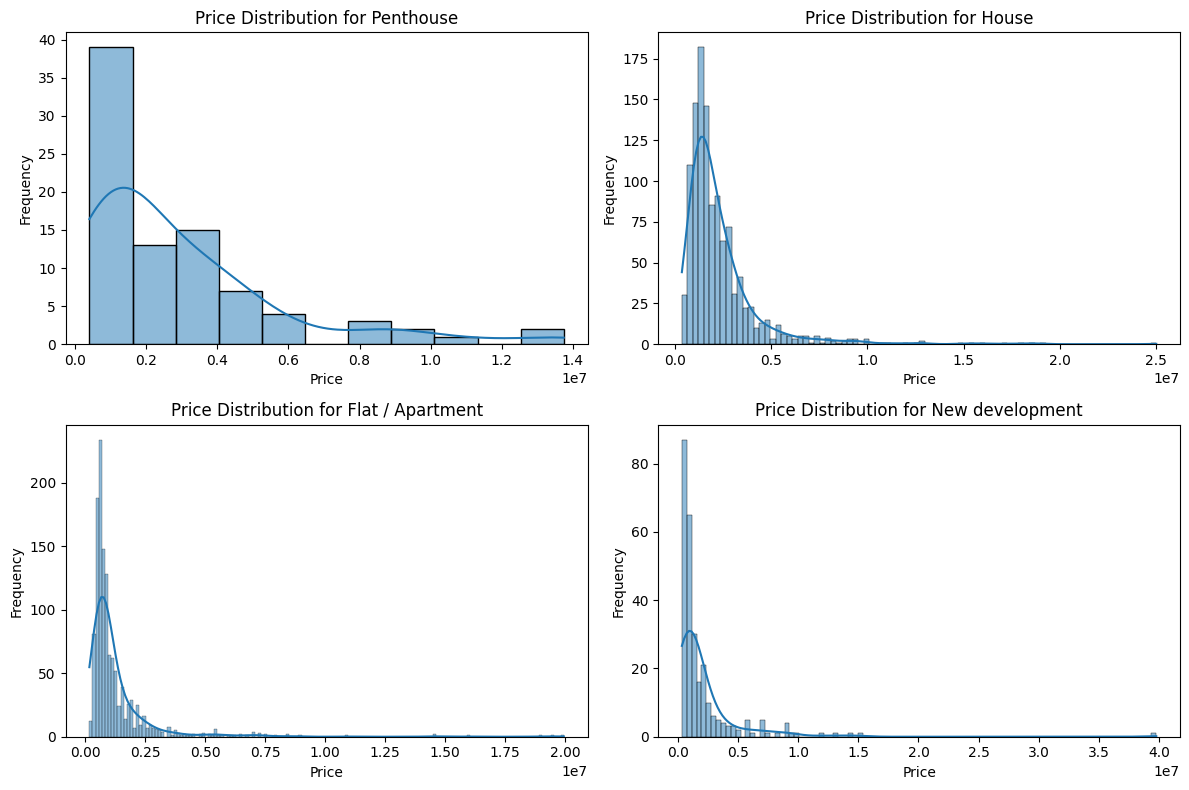

In [18]:
# check normality

plt.figure(figsize=(12,8))
for i, house_type in enumerate(temp_df["house_type"].unique(), 1):
    plt.subplot(2, 2, i)
    # filter the temp_df dataframe to include only rows 
    # where the house_type matches the current house_type in the loop.
    # then select price column from the filtered rows
    # kde=True adds a smooth kernel density estimate curve over the histogram,
    # providing a clearer view of the data's distribution
    sns.histplot(temp_df[temp_df["house_type"]==house_type]["price"], kde=True)
    plt.title(f"Price Distribution for {house_type}")
    plt.xlabel("Price")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
    

In [19]:
postal_code = postal_code.reset_index(drop=True)
temp_df['postal_code_truncated'] = postal_code.str.split().str[0]
temp_df.head()
temp_df.info()
temp_df['postal_code_truncated'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2784 entries, 0 to 2783
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   price                  2784 non-null   int64 
 1   area_in_sqft           2784 non-null   int64 
 2   no_bedrooms            2784 non-null   int64 
 3   house_type             2784 non-null   object
 4   postal_code_truncated  2784 non-null   object
dtypes: int64(3), object(2)
memory usage: 108.9+ KB


postal_code_truncated
SW11    188
SW18    143
N1      113
SW6     107
SW15     92
       ... 
RM4       1
EC2M      1
SE11      1
SE8       1
E20       1
Name: count, Length: 149, dtype: int64

Truncated postal code is still a lot of counts to be "categorized". Another solution is mapping post code to location name using api.

In [20]:
# fetch information for a postcode

def get_location_from_postcode_batch(postcodes):
    url = "https://api.postcodes.io/postcodes"
    headers = {"Content-Type": "application/json"}
    payload = {"postcodes": list(postcodes)}

    try:
        response = requests.post(url, json=payload, headers=headers)
        response.raise_for_status()
        data = response.json()

        locations = {}
        for result in data['result']:
            if result and result['result']:
                locations[result['query']] = result['result']['admin_district']
            else:
                locations[result['query']] = np.nan
        return locations
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return {postcode: np.nan for postcode in postcodes}

def map_postcodes_to_locations(df, column_name):
    unique_postcodes = df[column_name].unique()
    batch_size = 100

    location_mapping = {}
    for i in range(0, len(unique_postcodes), batch_size):
        batch = unique_postcodes[i:i+batch_size]
        location_mapping.update(get_location_from_postcode_batch(batch))

    df['location'] = df[column_name].map(location_mapping)
    return df
    

In [21]:
temp_df['postal_code'] = postal_code
temp_df = map_postcodes_to_locations(temp_df, 'postal_code')
print(temp_df)

        price  area_in_sqft  no_bedrooms        house_type  \
0      995000          1485            3         Penthouse   
1     1275000          1779            4             House   
2      635000           556            2  Flat / Apartment   
3     1225000          1510            4             House   
4     2895000          1850            3  Flat / Apartment   
...       ...           ...          ...               ...   
2779  2000000          2347            4   New development   
2780   489950           765            1             House   
2781   699950           787            2  Flat / Apartment   
2782   650000           595            2  Flat / Apartment   
2783  3650000          1616            2             House   

     postal_code_truncated postal_code                location  
0                     SE10    SE10 0NW               Greenwich  
1                     SW14    SW14 8BT    Richmond upon Thames  
2                       W6      W6 7QB  Hammersmith and Fulh

In [22]:
location = temp_df['location']
print(location.value_counts())

location
Wandsworth                547
Westminster               349
Kensington and Chelsea    228
Hammersmith and Fulham    197
Islington                 189
Richmond upon Thames      183
Camden                    152
Tower Hamlets             126
Elmbridge                 125
Hackney                   120
Lambeth                    99
Merton                     78
Ealing                     72
Hounslow                   52
Epping Forest              37
Hillingdon                 37
Kingston upon Thames       25
Southwark                  23
Greenwich                  19
Haringey                   17
City of London             14
Redbridge                  11
Reigate and Banstead       10
Three Rivers                9
Barnet                      9
Newham                      7
Watford                     7
Brent                       6
Lewisham                    6
Harrow                      4
Hertsmere                   2
Croydon                     2
Waltham Forest              2
S

Since it's only handful of unique locations, it can be used as feature.

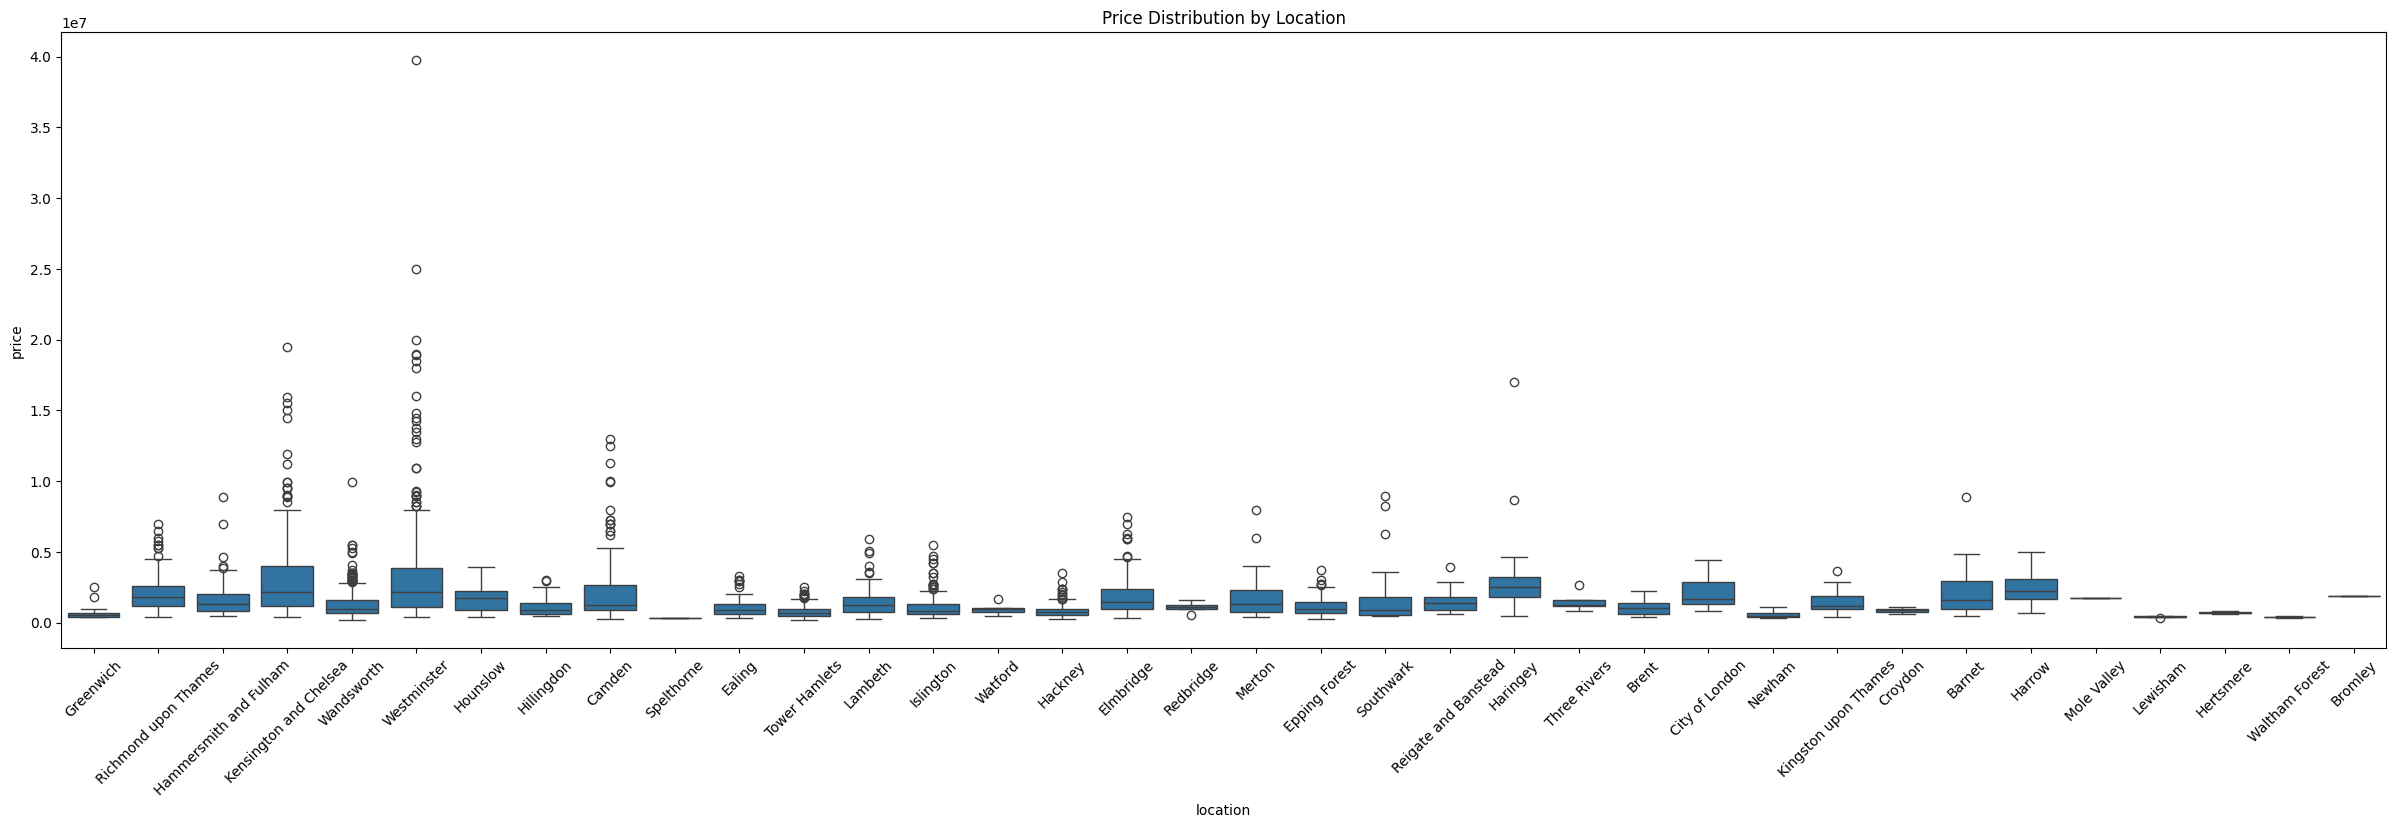

In [23]:
plt.figure(figsize=(30,8))
sns.boxplot(data=temp_df, x="location", y="price")
plt.xticks(rotation=45)
plt.title("Price Distribution by Location")
plt.show()

### Insights from the Boxplot
- the locations with more data (e.g. Wandsworth, Westminster) show broader price distributions and a significant number of outliers. These locations might be more influential in predicting the target variable (price)
- Locations with fewer data points seem to have a narrower price range and no significant outliers, meaning they likely won't contribute much variability to your model.

`mean_location`: mean value of price of each location group
`median_location`: median value of price of each location group
`std_summary`: standard deviation of price of each location group

In [24]:
# calculate summery statistics for each location
"""
group by their location, and get "each" records price (not the unique location after grouping), get their mean, median, std.
"""
location_summary = temp_df.groupby('location')['price'].agg(['mean', 'median', 'std']).reset_index()

# Get locations with more than 1 record
location_counts = temp_df['location'].value_counts()
valid_locations = location_counts[location_counts > 1].index

# Filter temp_df to keep only valid locations
temp_df = temp_df[temp_df['location'].isin(valid_locations)]

# Merge location_summary into temp_df with explicit suffix handling
temp_df = temp_df.merge(location_summary, on='location', how='left', suffixes=('', '_summary'))

# print(temp_df.columns)
# print(temp_df[['location', 'location_mean']].head())
# print(location_summary.head())
# print(location_summary.columns)

# Rename merged columns for clarity
temp_df.rename(columns={
    'mean': 'location_mean',
    'median': 'location_median',
    'std': 'location_std'
}, inplace=True)


### Determine feature relevance
1. Choose either encoded `location` name or use aggregated statistics (`location_mean`, `location_median`, `location_std`)
2. Drop if chose to use summary statistics
3. Explore relationships between `location` and other features (e.g. `no_bedrooms`, `house_type`) to see if the effect of location varies across these features.
4. Train a model - use the selected features (`location_mean` or encoded location names) as part of dataset, then train models like linear regression or decision tree and evaluate their performance. Compare results with and without location-related features to see their impact.

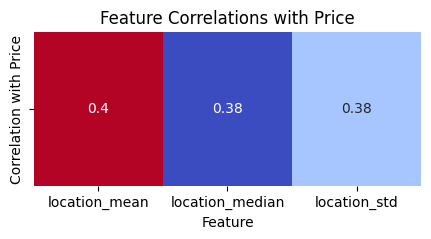

In [25]:
correlation_mean = temp_df['location_mean'].corr(temp_df['price'])
correlation_median = temp_df['location_median'].corr(temp_df['price'])
correlation_std = temp_df['location_std'].corr(temp_df['price'])

# Drop unnecessary columns if required
if 'mean' in temp_df.columns and 'median' in temp_df.columns and 'std' in temp_df.columns:
    temp_df.drop(['mean', 'median', 'std'], axis=1, inplace=True)

# Combine correlations into a DataFrame
correlations = pd.DataFrame({
    'Feature': ['location_mean', 'location_median', 'location_std'],
    'Correlation with Price': [correlation_mean, correlation_median, correlation_std]
})

# Reshape for heatmap
correlation_matrix = correlations.set_index('Feature').T

# Plot heatmap
plt.figure(figsize=(5, 2))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=False)
plt.title("Feature Correlations with Price")
plt.show()

choose `location_mean` since it shows the highest correlation with price, and use other statistics as additional stats.

<Axes: xlabel='location_mean', ylabel='price'>

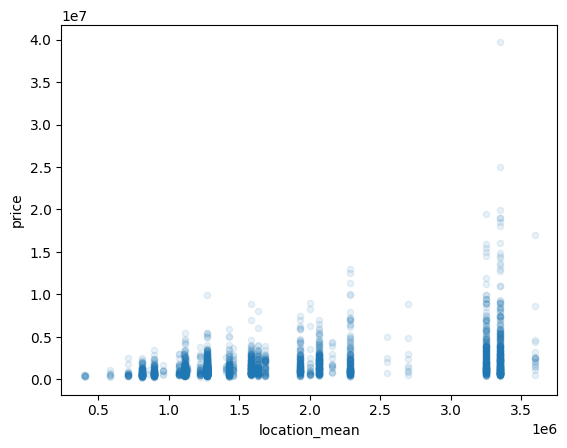

In [26]:
temp_df.plot(kind="scatter", x="location_mean", y="price", alpha=0.1)

## Encoded Name vs Location Statistics
### Relationship between location_mean and price
The scatter plot shows positive relationship, but is not perfectly linear. While `location_mean` captures some information, it summarizes location data into a single statistics, which may lose nuances that directly encoded names could preserve.

### Encoded Location Names
Encoding the location names (via one-hot encoding or label encoding) allows the model to learn from the *full granularity* of location. However, one-hot encoding can create a very sparse matrix if I have too many unique locations. If this is the case, it could increase the complexity and overfit the model, especially for smaller datasets.

## Check for Interactions Between Features
Investigating whether there are interactions between location and other features such as `no_bedrooms`, `house_type`.
#### 1. Group by Location and Other Features
check how `price` varies within `location` for different numbers of bedrooms or house types.

<Axes: xlabel='location'>

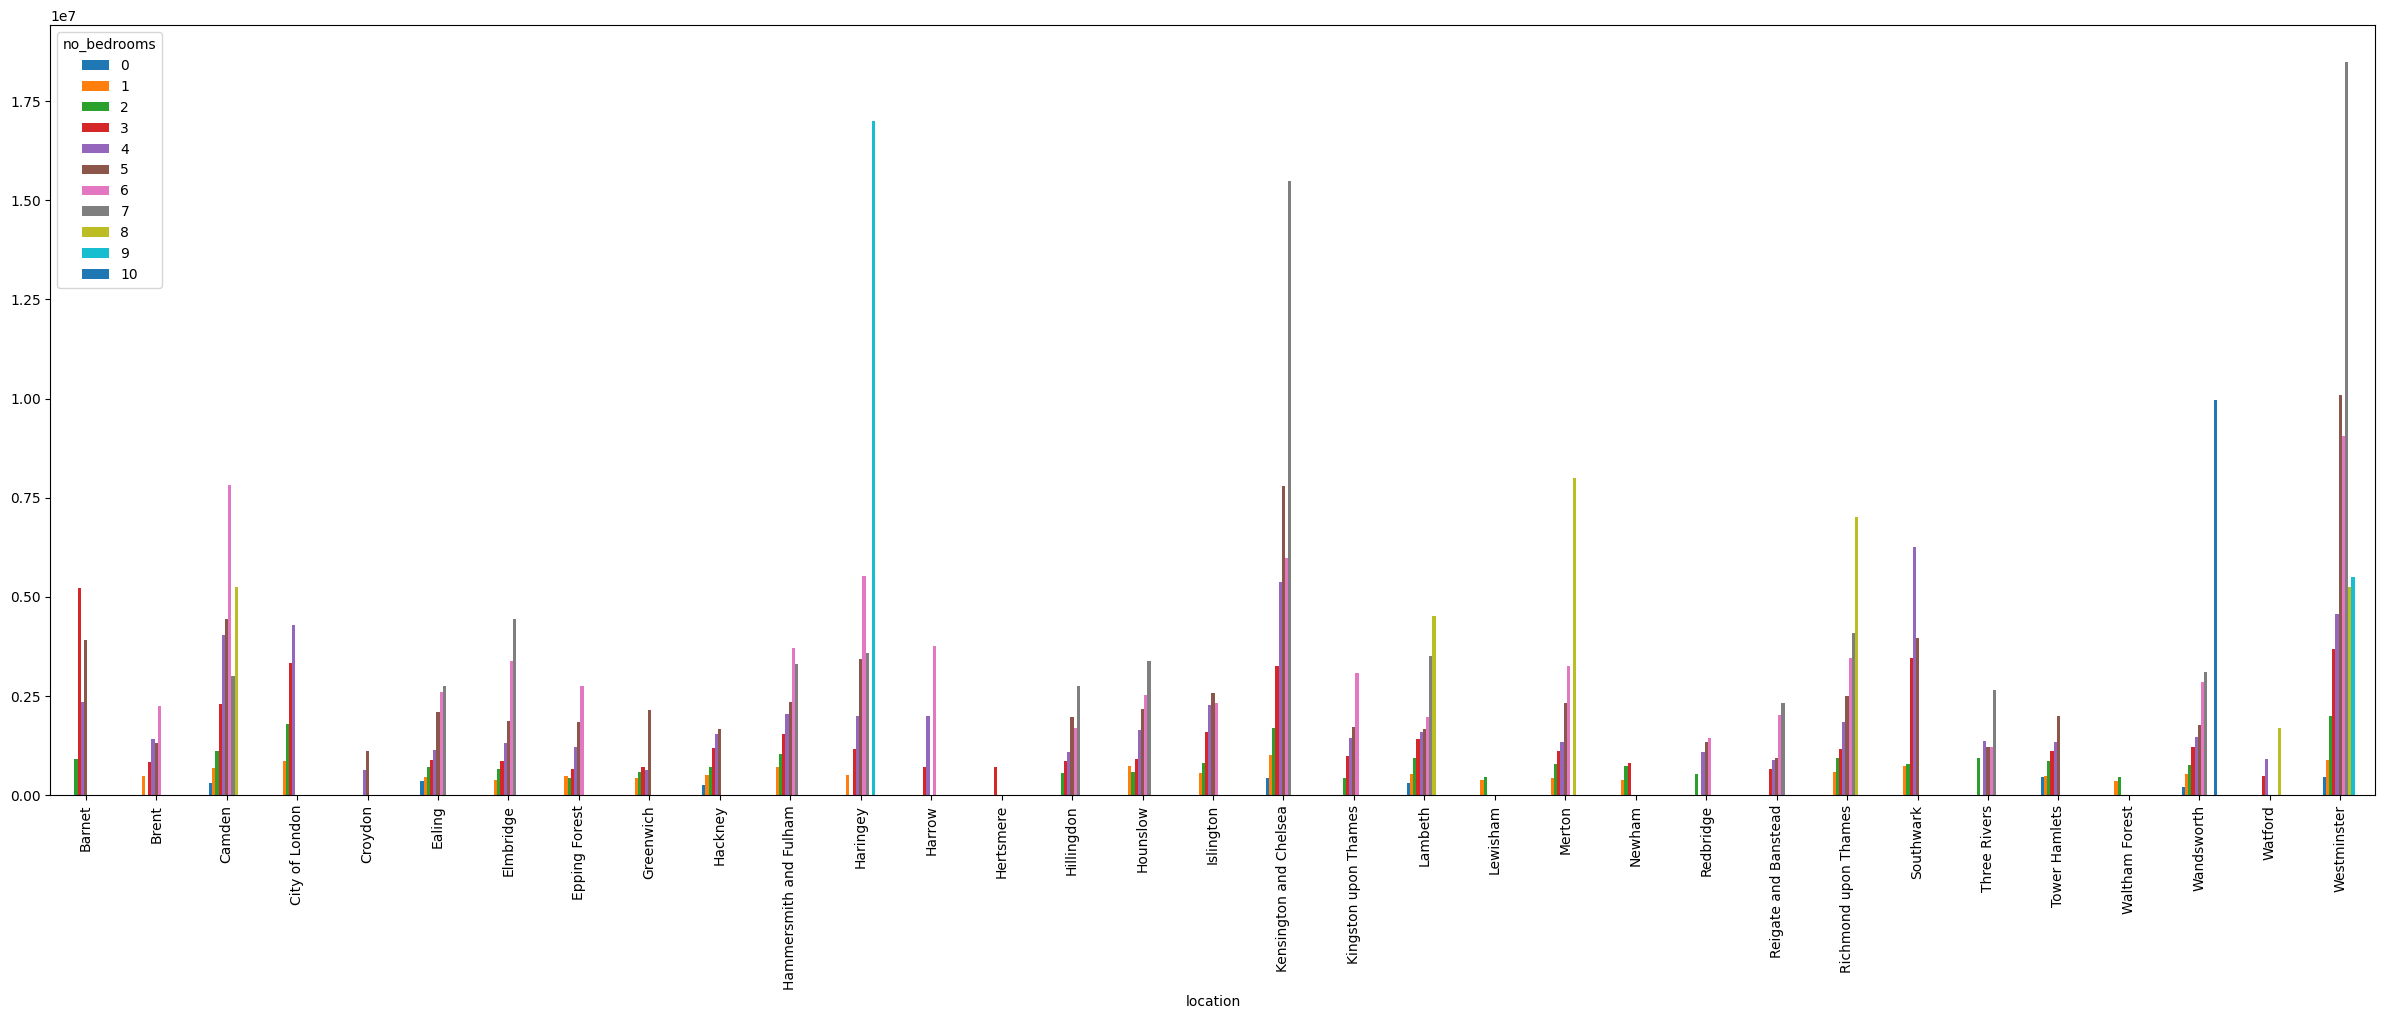

In [27]:
interaction_summary = temp_df.groupby(['location', 'no_bedrooms'])['price'].mean().unstack()
interaction_summary.plot(kind='bar', figsize=(30, 10))

### Bar plot of the mean price of properties grouped by location and number of bedrooms
**Variation:** There is significant variation in mean prices across locations. Bars of locations like *Kensington and Chelsea* or *Westminster* shows consistently much higher (thick and tall), meaning property prices in those locations are much higher compared to others.

**Effect of no_bedrooms:** properties with more bedrooms tend to have higher mean prices, which aligns with general market trends. Some locations have a sharp jump in prices for higher bedrooms (e.g. `Heringey` with 9 bedrooms showing very high mean price). This might indicate luxury properties.

**Outliers and Data Skew:** Some locations have unusually high prices for a specific number of bedrooms (e.g. `Haringey` and `Wandsworth`), which may indicate outliers or unique market conditions.

**Data Gaps:** For some combination of `location` and `no_bedrooms`, there are no bars, meaning there is no data available. This might require further investigation to ensure data completeness. 

#### 2. Pairplot for Continuous Features
Use a pairplot to observe how continuous variables interact with `price` and other features.

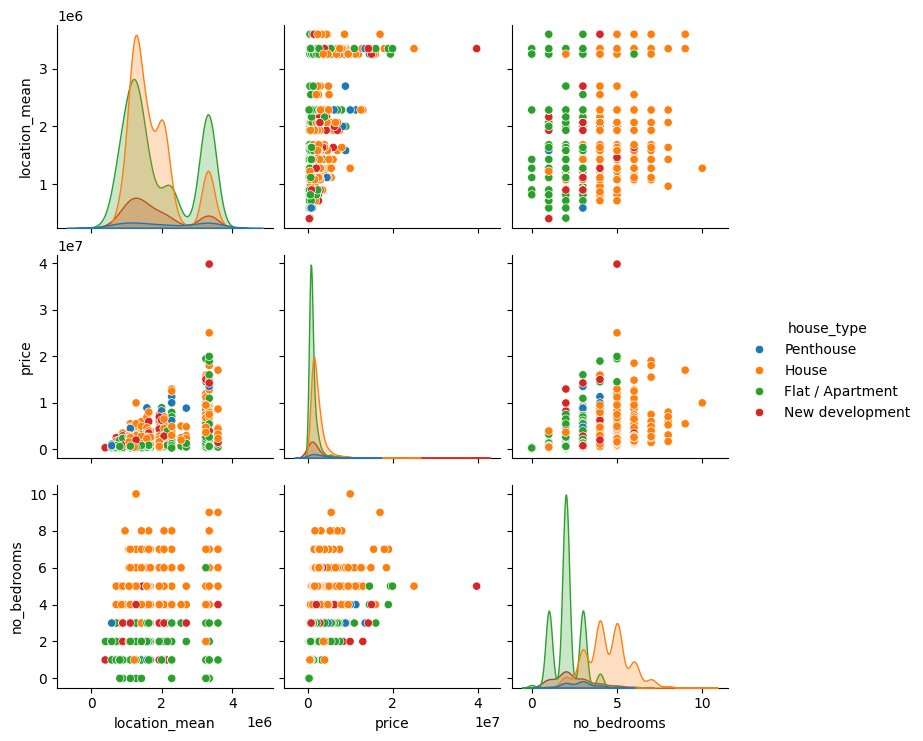

In [28]:
sns.pairplot(temp_df, vars=['location_mean', 'price', 'no_bedrooms'], hue='house_type', height=2.5)

- Location mean and number of bedrooms are strong predictors of price.
- House type significantly influences the relationships between these variables.
- The data exhibits skewness in price and location mean, indicating the presence of high-value properties and areas.

## Outlier inspection for price and no_bedrooms
1. **Visual inspection** to detemt unusual values
2. **Calculate Z-Scores** Z-scores measure how far a value is from the mean in terms of standard deviations. Values with |Z|>3 are often considered outliers. Z store function standardizes the `price` column by calculating the Z-score for each data point:
   Z  = (each price - (mean of all price))/ standard deviation of all prices
Z-score beyond +-3 is considered an extreme value in a normal distribution (about 0.3% of the data).

**Zscore -> IQR-Based Filtering:** since zscore is sensitive to skewed distribution, and we have skewed distribution for price, try IQR filtering to remove extreme high prices.

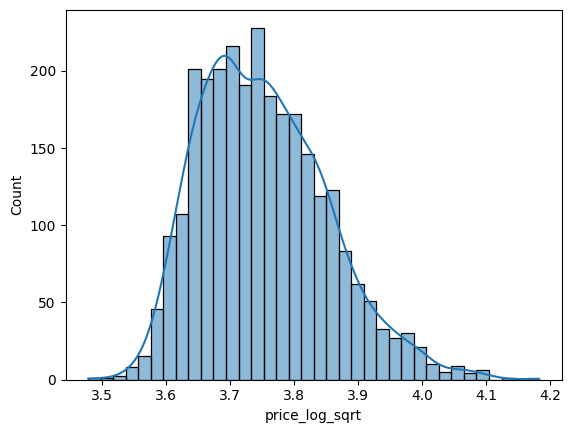

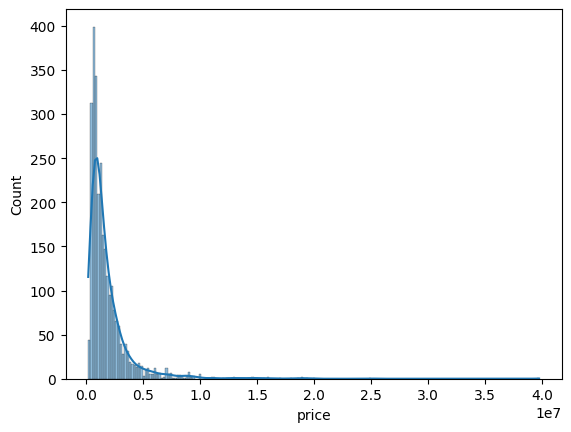

In [29]:
temp_df['price_log'] = np.log1p(temp_df['price'])
temp_df['price_boxcox'], _ = stats.boxcox(temp_df['price'])
temp_df['price_log_sqrt'] = np.sqrt(temp_df['price_log'])

sns.histplot(temp_df['price_log_sqrt'], kde=True)  
plt.show()
sns.histplot(temp_df['price'], kde=True)  
plt.show()

#### Check skewness
if **skewness < 0.5**, it's nearly normal
if **skewness > 1**, consider **further transformation**

In [30]:
# Check skewness
print(skew(temp_df['price_log_sqrt']))


0.5753152650922544


#### Further reducing skewness through Yeo-Johnson Transformation
- `transformed_price`: NumPy array containing the transformed values.
- `lambda_value`: the optimal lambda value found by the transformation. It indicates the power to which the data was raised.

In [31]:
transformed_price, lambda_value = stats.yeojohnson(temp_df['price_log_sqrt'])
temp_df['price_yeojohnson'] = transformed_price

print(f"Lambda value: {lambda_value}")

Lambda value: -9.355838731329055


Text(0.5, 1.0, 'Boxplot of price')

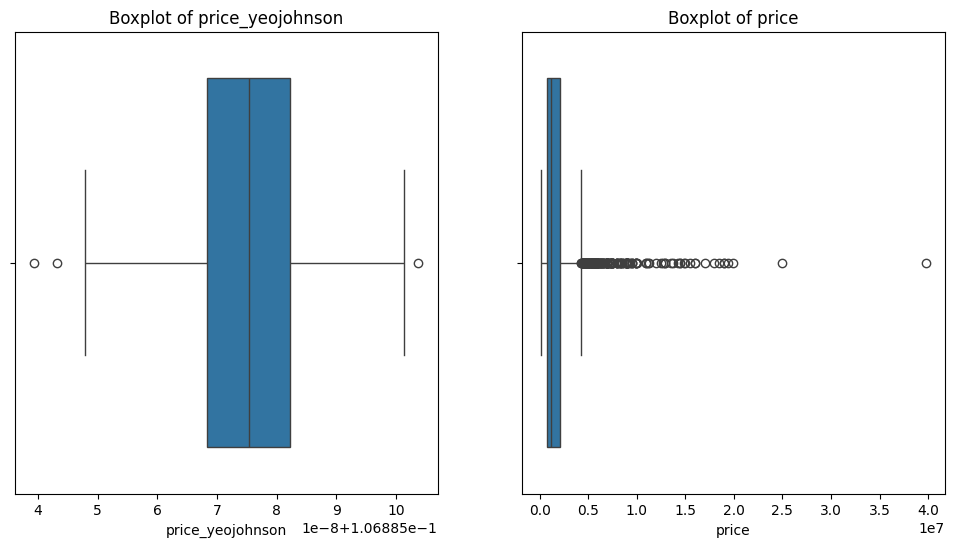

In [32]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x=temp_df['price_yeojohnson'])
plt.title('Boxplot of price_yeojohnson')

plt.subplot(1, 2, 2)
sns.boxplot(x=temp_df['price'])
plt.title('Boxplot of price')

In [33]:
print(skew(temp_df['price_yeojohnson']))

0.028315857695354156


## Standardization
centers the data at 0 and scales it to have unit variance. (X - mean_of price) / standard deviation of price

#### Checking Standardization
expected result after standardization:
- mean of scaled price is close to 0
- standard deviation is close to 1

In [34]:
scaler = StandardScaler()
temp_df['price_scaled'] = scaler.fit_transform(temp_df[['price_yeojohnson']])

In [35]:
# Check standardization correctness
mean_scaled = temp_df['price_scaled'].mean()
std_scaled = temp_df['price_scaled'].std()

print(f"Mean of price_scaled: {mean_scaled}")
print(F"Standard deviation of price_scaled: {std_scaled}")

Mean of price_scaled: -5.867766848066363e-10
Standard deviation of price_scaled: 1.0001809463508884


### Minimise multicollinearity
Multicollinearity can significantly impact the interpretation and performance of regression models. 
In correlation matrix, high correlation coefficients (close to +1 or -1) indicate strong linear relationships.
each independent variable has a coefficient
coefficient = its impact on the dependent variable
variance of coefficient = measures uncertainty. The higher variance the more uncertainty it is.
If two variables are highly correlated, the regression model has difficulty distinguishing their individual effects. This leads to less precise estimates of the coefficients, meaning higher variance.

Looking at the heatmap, `no_bedrooms` and `location_mean` don't have correlation.

In [36]:
temp_df['interaction'] = temp_df['location_mean'] * temp_df['no_bedrooms']

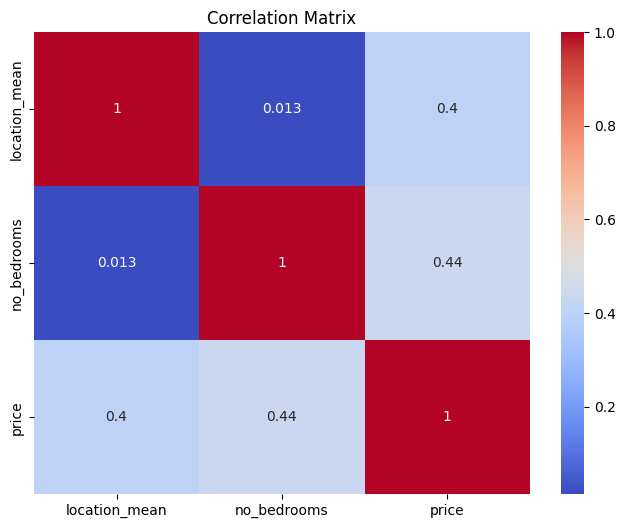

In [37]:
correlation_matrix = temp_df[['location_mean', 'no_bedrooms', 'price']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [38]:
housing = temp_df
columns_to_keep = ["no_bedrooms", "location_mean", "price_scaled"]
original_price_train = housing['price'].copy()

for column in housing.columns:
    if column in columns_to_keep: continue
    housing.drop(column, axis=1, inplace=True)    

### Prepare Features (X) and Target (Y) for Training
Ensure that features don't include the target variable as a feature in my training data.
Apply `.fit()` only to train set.

In [39]:
X_train_scaled = housing.drop('price_scaled', axis=1)
y_train_scaled = housing['price_scaled']

model_scaled = RandomForestRegressor(random_state=42)
model_scaled.fit(X_train_scaled, y_train_scaled)

RandomForestRegressor(random_state=42)

In [ ]:
# Price Transformation Pipeline
class PriceTransformer:
    def __init__(self):
        self.pt = PowerTransformer(method='yeo-johnson')
        self.scaler = StandardScaler()

        def fit(self, y):
            y_transformed = np.sqrt(np.log1p(y))
            y_yeojohnson = self.pt.fit_transform(y_transformed.reshape(-1, 1))
            self.scaler.fit(y_yeojohnson)
            return self

        def transform(self, y):
            y_transformed = np.sqrt(np.log1p(y))
            y_yeojohnson = self.pt.transform(y_transformed.reshape(-1, 1))
            return self.scaler.transform(y_yeojohnson)

        def inverse_transform(self, y_scaled):   
            y_yeojohnson = self.scaler.inverse_transform(y_scaled)
            y_transformed = self.pt.inverse_transform(y_yeojohnson)
            y_original = np.expm1(np.square(y_transformed))
            return y_original

### Transform Test sets


In [ ]:
strat_test_set["location_mean"] = strat_test_set["location"].map(location_means)
overall_mean = housing["location_mean"]
strat_test_set["location_mean"].fillna(overall_mean, inplace=True)

In [ ]:
y_test = strat_test_set['price'].copy()

price_transformer = PriceTransformer()
y_test_scaled = price_transformer.transform(y_test)

Index(['no_bedrooms', 'location_mean', 'price_scaled'], dtype='object')


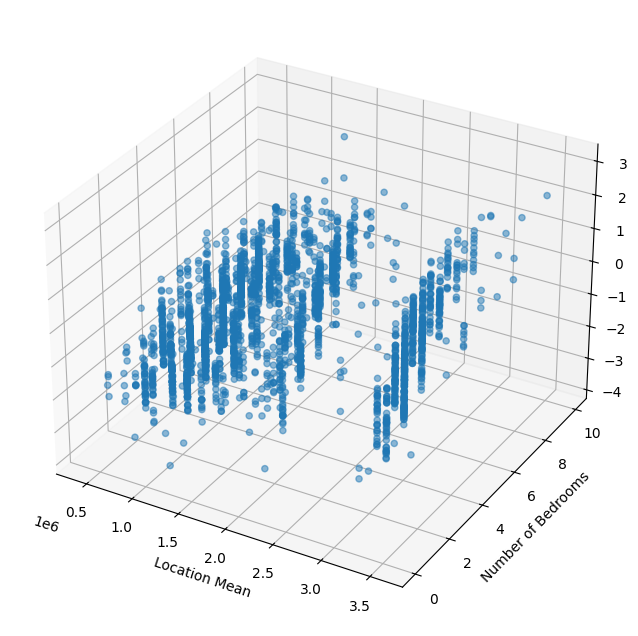

In [40]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
print(temp_df.columns)
ax.scatter(temp_df['location_mean'], temp_df['no_bedrooms'], temp_df['price_scaled'], alpha=0.5)
ax.set_xlabel('Location Mean')
ax.set_ylabel('Number of Bedrooms')
ax.set_zlabel('Price')
plt.show()